<a href="https://colab.research.google.com/github/Nadezda-Sut/EEG/blob/main/MNE_Connectivity_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mne




In [3]:
!pip install autoreject

In [4]:

!pip install -U mne-connectivity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.3 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2023.7.0
    Uninstalling xarray-2023.7.0:
      Successfully uninstalled xarray-2023.7.0


In [ ]:
import matplotlib
import pathlib
import mne
import pandas as pd
import numpy as np
from autoreject  import AutoReject
ar = AutoReject()
from mne_connectivity import spectral_connectivity_epochs



In [5]:
from google.colab import drive
import mne
import pandas as pd
import numpy as np
import os
import pathlib
from mne_connectivity.spectral import spectral_connectivity_epochs

# Mount Google Drive
drive.mount('/content/gdrive')

# Define the directory containing .set files
input_dir_path = "/content/gdrive/My Drive/delite"
montage_file_path = "/content/gdrive/My Drive/Colab Notebooks/Channels.csv"

# Parameters for the analysis
epochs_duration = 3.0
epochs_overlap = 0.5
con_methods = ['wpli']  # Connectivity methods
con_freqs = [(8, 13)]  # Define as tuples for min and max frequencies

def process_file(file_path, output_dir_path):
    base_filename = os.path.splitext(os.path.basename(file_path))[0]
    output_file_path = f"{output_dir_path}/{base_filename}_raw.fif"

    # Read the EEG data
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    # Save the preprocessed raw data
    raw.save(output_file_path, overwrite=True)

    # Read and set the montage
    montage = mne.channels.read_custom_montage(montage_file_path)
    raw.set_montage(montage, on_missing='warn')

    # Epoching
    epochs = epoching(raw, epochs_duration, epochs_overlap)

    # Calculate and save connectivity
    calculate_conn(epochs, con_methods, epochs.info['sfreq'], con_freqs, base_filename, pathlib.Path(output_dir_path))

def epoching(raw, duration, overlap):
    events = mne.make_fixed_length_events(raw, id=1, duration=duration - overlap)
    epochs = mne.Epochs(raw, events, tmin=0, tmax=duration, baseline=(0, 0), reject_by_annotation=True)
    epochs.drop_bad()
    return epochs

def calculate_conn(data, con_methods, sfreq, con_freqs, person, output_folder):
    for method in con_methods:
        for fmin, fmax in con_freqs:
            con = spectral_connectivity_epochs(
                data=data,
                method=method,
                sfreq=sfreq,
                fmin=fmin,
                fmax=fmax,
                faverage=True,
                mt_adaptive=True,
                n_jobs=1,
                verbose=True
            )
            # Extract connectivity matrix for all frequency points (assuming dense output)
            con_matrix = con.get_data(output='dense')

            # Handle multiple frequencies by averaging (if necessary)
            if con_matrix.shape[2] > 1:
                # Averaging across the frequency dimension if there are multiple frequencies
                con_matrix_avg = np.mean(con_matrix, axis=2)
            else:
                # Use the single frequency point directly
                con_matrix_avg = con_matrix[:, :, 0]

            # Save the connectivity matrix to CSV
            output_filename = f"{output_folder}/{person}_{method}_{fmin}-{fmax}Hz.csv"
            pd.DataFrame(con_matrix_avg, index=data.ch_names, columns=data.ch_names).to_csv(output_filename)

# Iterate over all .set files in the specified directory
for filename in os.listdir(input_dir_path):
    if filename.endswith('.set'):
        file_path = os.path.join(input_dir_path, filename)
        print(f"Processing file: {file_path}")
        process_file(file_path, input_dir_path)


Mounted at /content/gdrive
Processing file: /content/gdrive/My Drive/delite/6KVDo.set
Reading /content/gdrive/My Drive/delite/6KVDo.fdt


<ipython-input-5-4135968d0a1f>:27: RuntimeWarning: Data file name in EEG.data (KalinchenkoVasiliDoo.fdt) is incorrect, the file name must have changed on disk, using the correct file name (6KVDo.fdt).
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


Reading 0 ... 73912  =      0.000 ...   288.719 secs...
Overwriting existing file.
Writing /content/gdrive/My Drive/delite/6KVDo_raw.fif


<ipython-input-5-4135968d0a1f>:27: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


Closing /content/gdrive/My Drive/delite/6KVDo_raw.fif
[done]
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 115 events and 769 original time points ...
0 bad epochs dropped
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..3.000s for estimation (769 points)
    frequencies: 8.3Hz..13.0Hz (15 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epoch 1


<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: DigMontage is only a subset of info. There are 61 channel positions not present in the DigMontage. The channels missing from the montage are:

['AF7', 'AF3', 'Fp1', 'Fp2', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'FT8', 'T3', 'C5', 'C3', 'C1', 'C2', 'C4', 'C6', 'T4', 'TP7', 'CP5', 'CP3', 'CP1', 'CP2', 'CP4', 'CP6', 'TP8', 'T5', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6', 'T6', 'Fpz', 'PO7', 'PO3', 'O1', 'O2', 'PO4', 'PO8', 'OZ', 'AFz', 'FZ', 'FCZ', 'CZ', 'CPZ', 'PZ', 'POZ'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses

    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    computing cross-spectral density for epoch 21
    comp

<ipython-input-5-4135968d0a1f>:27: RuntimeWarning: Data file name in EEG.data (KalinchenkoVasiliPoslee.fdt) is incorrect, the file name must have changed on disk, using the correct file name (6KVPosle.fdt).
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


Overwriting existing file.
Writing /content/gdrive/My Drive/delite/6KVPosle_raw.fif


<ipython-input-5-4135968d0a1f>:27: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


Closing /content/gdrive/My Drive/delite/6KVPosle_raw.fif
[done]
Not setting metadata
119 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 119 events and 769 original time points ...
0 bad epochs dropped
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..3.000s for estimation (769 points)
    frequencies: 8.3Hz..13.0Hz (15 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2


<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: DigMontage is only a subset of info. There are 61 channel positions not present in the DigMontage. The channels missing from the montage are:

['AF7', 'AF3', 'Fp1', 'Fp2', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'FT8', 'T3', 'C5', 'C3', 'C1', 'C2', 'C4', 'C6', 'T4', 'TP7', 'CP5', 'CP3', 'CP1', 'CP2', 'CP4', 'CP6', 'TP8', 'T5', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6', 'T6', 'Fpz', 'PO7', 'PO3', 'O1', 'O2', 'PO4', 'PO8', 'OZ', 'AFz', 'FZ', 'FCZ', 'CZ', 'CPZ', 'PZ', 'POZ'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses

    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    computing cross-spectral density for epoch 21
    computing cross-spectral density for epoch 22
    com

<ipython-input-5-4135968d0a1f>:27: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


Closing /content/gdrive/My Drive/delite/1IEDo_raw.fif
[done]
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 115 events and 769 original time points ...
1 bad epochs dropped
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..3.000s for estimation (769 points)
    frequencies: 8.3Hz..13.0Hz (15 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epoch 1


<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: DigMontage is only a subset of info. There are 61 channel positions not present in the DigMontage. The channels missing from the montage are:

['AF7', 'AF3', 'Fp1', 'Fp2', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'FT8', 'T3', 'C5', 'C3', 'C1', 'C2', 'C4', 'C6', 'T4', 'TP7', 'CP5', 'CP3', 'CP1', 'CP2', 'CP4', 'CP6', 'TP8', 'T5', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6', 'T6', 'Fpz', 'PO7', 'PO3', 'O1', 'O2', 'PO4', 'PO8', 'OZ', 'AFz', 'FZ', 'FCZ', 'CZ', 'CPZ', 'PZ', 'POZ'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses

    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    computing cross-spectral density for epoch 21
    comp

<ipython-input-5-4135968d0a1f>:27: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


Closing /content/gdrive/My Drive/delite/1IEPosle_raw.fif
[done]
Not setting metadata
113 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 113 events and 769 original time points ...
0 bad epochs dropped
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..3.000s for estimation (769 points)
    frequencies: 8.3Hz..13.0Hz (15 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2


<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: DigMontage is only a subset of info. There are 61 channel positions not present in the DigMontage. The channels missing from the montage are:

['AF7', 'AF3', 'Fp1', 'Fp2', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'FT8', 'T3', 'C5', 'C3', 'C1', 'C2', 'C4', 'C6', 'T4', 'TP7', 'CP5', 'CP3', 'CP1', 'CP2', 'CP4', 'CP6', 'TP8', 'T5', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6', 'T6', 'Fpz', 'PO7', 'PO3', 'O1', 'O2', 'PO4', 'PO8', 'OZ', 'AFz', 'FZ', 'FCZ', 'CZ', 'CPZ', 'PZ', 'POZ'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses

    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    computing cross-spectral density for epoch 21
    computing cross-spectral density for epoch 22
    com

<ipython-input-5-4135968d0a1f>:27: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
<ipython-input-5-4135968d0a1f>:27: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


Closing /content/gdrive/My Drive/delite/5ShZDoICA_raw.fif
[done]
Not setting metadata
108 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 108 events and 769 original time points ...


<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: DigMontage is only a subset of info. There are 61 channel positions not present in the DigMontage. The channels missing from the montage are:

['AF7', 'AF3', 'Fp1', 'Fp2', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'FT8', 'T3', 'C5', 'C3', 'C1', 'C2', 'C4', 'C6', 'T4', 'TP7', 'CP5', 'CP3', 'CP1', 'CP2', 'CP4', 'CP6', 'TP8', 'T5', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6', 'T6', 'Fpz', 'PO7', 'PO3', 'O1', 'O2', 'PO4', 'PO8', 'OZ', 'AFz', 'FZ', 'FCZ', 'CZ', 'CPZ', 'PZ', 'POZ'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses

0 bad epochs dropped
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..3.000s for estimation (769 points)
    frequencies: 8.3Hz..13.0Hz (15 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-s

<ipython-input-5-4135968d0a1f>:27: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


Closing /content/gdrive/My Drive/delite/5ShZPosleICA_raw.fif
[done]
Not setting metadata
132 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 132 events and 769 original time points ...
0 bad epochs dropped
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..3.000s for estimation (769 points)
    frequencies: 8.3Hz..13.0Hz (15 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2


<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: DigMontage is only a subset of info. There are 61 channel positions not present in the DigMontage. The channels missing from the montage are:

['AF7', 'AF3', 'Fp1', 'Fp2', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'FT8', 'T3', 'C5', 'C3', 'C1', 'C2', 'C4', 'C6', 'T4', 'TP7', 'CP5', 'CP3', 'CP1', 'CP2', 'CP4', 'CP6', 'TP8', 'T5', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6', 'T6', 'Fpz', 'PO7', 'PO3', 'O1', 'O2', 'PO4', 'PO8', 'OZ', 'AFz', 'FZ', 'FCZ', 'CZ', 'CPZ', 'PZ', 'POZ'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses

    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    computing cross-spectral density for epoch 21
    computing cross-spectral density for epoch 22
    com

<ipython-input-5-4135968d0a1f>:27: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
<ipython-input-5-4135968d0a1f>:27: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


Closing /content/gdrive/My Drive/delite/3MVDo_raw.fif
[done]
Not setting metadata
117 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 117 events and 769 original time points ...
0 bad epochs dropped
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..3.000s for estimation (769 points)
    frequencies: 8.3Hz..13.0Hz (15 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epoch 1


<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: DigMontage is only a subset of info. There are 61 channel positions not present in the DigMontage. The channels missing from the montage are:

['AF7', 'AF3', 'Fp1', 'Fp2', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'FT8', 'T3', 'C5', 'C3', 'C1', 'C2', 'C4', 'C6', 'T4', 'TP7', 'CP5', 'CP3', 'CP1', 'CP2', 'CP4', 'CP6', 'TP8', 'T5', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6', 'T6', 'Fpz', 'PO7', 'PO3', 'O1', 'O2', 'PO4', 'PO8', 'OZ', 'AFz', 'FZ', 'FCZ', 'CZ', 'CPZ', 'PZ', 'POZ'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses

    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    computing cross-spectral density for epoch 21
    comp

<ipython-input-5-4135968d0a1f>:27: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
<ipython-input-5-4135968d0a1f>:27: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)


Closing /content/gdrive/My Drive/delite/3MVPosle_raw.fif
[done]
Not setting metadata
111 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 111 events and 769 original time points ...
0 bad epochs dropped
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..3.000s for estimation (769 points)
    frequencies: 8.3Hz..13.0Hz (15 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2


<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')
<ipython-input-5-4135968d0a1f>:33: RuntimeWarning: DigMontage is only a subset of info. There are 61 channel positions not present in the DigMontage. The channels missing from the montage are:

['AF7', 'AF3', 'Fp1', 'Fp2', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'FT8', 'T3', 'C5', 'C3', 'C1', 'C2', 'C4', 'C6', 'T4', 'TP7', 'CP5', 'CP3', 'CP1', 'CP2', 'CP4', 'CP6', 'TP8', 'T5', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6', 'T6', 'Fpz', 'PO7', 'PO3', 'O1', 'O2', 'PO4', 'PO8', 'OZ', 'AFz', 'FZ', 'FCZ', 'CZ', 'CPZ', 'PZ', 'POZ'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses

    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    computing cross-spectral density for epoch 21
    computing cross-spectral density for epoch 22
    com

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os
import networkx.algorithms.community as nx_comm
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Directory where your CSV files are stored
input_dir_path = "/content/gdrive/My Drive/delite"

# Path to save the summary CSV
summary_csv_path = "/content/gdrive/My Drive/delite/EEG_Analysis_Summary.csv"

# Initialize an empty DataFrame to store metrics
metrics_summary = pd.DataFrame(columns=["File", "Modularity", "Global Efficiency", "Global Connectivity Index", "Network Density", "Clustering Coefficient", "Average Path Length", "Small-World Index"])

# Function to process a single file and calculate metrics
def process_and_calculate_metrics(file_path):
    connectivity_matrix = pd.read_csv(file_path, index_col=0)
    np.fill_diagonal(connectivity_matrix.values, 0)

    threshold = 0.5
    binary_matrix = (connectivity_matrix > threshold).astype(int)

    global_connectivity_index = connectivity_matrix.mean().mean()
    network_density = np.sum(binary_matrix.values) / (len(binary_matrix) * (len(binary_matrix) - 1))

    G_binary = nx.from_pandas_adjacency(binary_matrix)

    largest_cc = max(nx.connected_components(G_binary), key=len)
    subgraph = G_binary.subgraph(largest_cc)
    clustering_coefficient_lcc = nx.average_clustering(subgraph)
    average_path_length = nx.average_shortest_path_length(subgraph)

    random_graph = nx.gnm_random_graph(n=G_binary.number_of_nodes(), m=G_binary.number_of_edges())
    largest_cc_random = max(nx.connected_components(random_graph), key=len)
    subgraph_random = random_graph.subgraph(largest_cc_random)
    random_clustering_coefficient = nx.average_clustering(subgraph_random)
    random_path_length = nx.average_shortest_path_length(subgraph_random)

    sigma = (clustering_coefficient_lcc / random_clustering_coefficient) / (average_path_length / random_path_length)
    global_efficiency = nx.global_efficiency(G_binary)

    communities = nx_comm.louvain_communities(G_binary)
    modularity = nx_comm.modularity(G_binary, communities)

    return {
        "File": os.path.basename(file_path),
        "Modularity": modularity,
        "Global Efficiency": global_efficiency,
        "Global Connectivity Index": global_connectivity_index,
        "Network Density": network_density,
        "Clustering Coefficient": clustering_coefficient_lcc,
        "Average Path Length": average_path_length,
        "Small-World Index": sigma
    }

# Iterate over all CSV files in the directory
for filename in os.listdir(input_dir_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(input_dir_path, filename)
        print(f"Processing file: {file_path}")
        metrics = process_and_calculate_metrics(file_path)
        metrics_summary = metrics_summary.append(metrics, ignore_index=True)

# Save the metrics summary to a CSV file
metrics_summary.to_csv(summary_csv_path, index=False)
print(f"Metrics summary saved to {summary_csv_path}")


Processing file: /content/gdrive/My Drive/delite/6KVDo_wpli_8-13Hz.csv
Processing file: /content/gdrive/My Drive/delite/6KVPosle_wpli_8-13Hz.csv
Processing file: /content/gdrive/My Drive/delite/1IEDo_wpli_8-13Hz.csv


<ipython-input-7-e3661997e052>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_summary = metrics_summary.append(metrics, ignore_index=True)
<ipython-input-7-e3661997e052>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_summary = metrics_summary.append(metrics, ignore_index=True)
<ipython-input-7-e3661997e052>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_summary = metrics_summary.append(metrics, ignore_index=True)
<ipython-input-7-e3661997e052>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_summary = metrics_summary.append(metrics, ignore_index=True)


Processing file: /content/gdrive/My Drive/delite/1IEPosle_wpli_8-13Hz.csv
Processing file: /content/gdrive/My Drive/delite/5ShZDoICA_wpli_8-13Hz.csv


<ipython-input-7-e3661997e052>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_summary = metrics_summary.append(metrics, ignore_index=True)
<ipython-input-7-e3661997e052>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_summary = metrics_summary.append(metrics, ignore_index=True)
<ipython-input-7-e3661997e052>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_summary = metrics_summary.append(metrics, ignore_index=True)


Processing file: /content/gdrive/My Drive/delite/5ShZPosleICA_wpli_8-13Hz.csv
Processing file: /content/gdrive/My Drive/delite/3MVDo_wpli_8-13Hz.csv
Processing file: /content/gdrive/My Drive/delite/3MVPosle_wpli_8-13Hz.csv
Metrics summary saved to /content/gdrive/My Drive/delite/EEG_Analysis_Summary.csv


<ipython-input-7-e3661997e052>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_summary = metrics_summary.append(metrics, ignore_index=True)


In [ ]:
#main_folder = pathlib.Path().cwd()

#input_folder = pathlib.Path('D:/eeg_connectivity')
#output_folder = pathlib.Path('D:/eeg_connectivity/output')



#files = [file for file in input_folder.iterdir() if file.suffix == '.fif']

#files = 'D:/eeg_connectivity/VatEvgDoICA.set'


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


# path to file in google drive

file_path = "/content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ/BahTimPosleCleanICA.set"


Mounted at /content/gdrive


In [ ]:
input_file = '/content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ/BahTimPosleCleanICA.set'
output_file = '/content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ/BahTimPosleCleanICA.fif'

# Read the EEG data from the input file
raw = mne.io.read_raw_eeglab(input_file, preload=True)

# Save the EEG data to the output file in FIF format
raw.save(output_file, overwrite=True)

Reading /content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ/BahTimPosleCleanICA.fdt
Reading 0 ... 170070  =      0.000 ...   166.084 secs...
Overwriting existing file.
Writing /content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ/BahTimPosleCleanICA.fif


<ipython-input-6-4512cb01e98f>:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(input_file, preload=True)
<ipython-input-6-4512cb01e98f>:5: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(input_file, preload=True)
<ipython-input-6-4512cb01e98f>:8: RuntimeWarning: This filename (/content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ/BahTimPosleCleanICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_file, overwrite=True)


Closing /content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ/BahTimPosleCleanICA.fif
[done]


In [ ]:
file = '/content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ/BahTimPosleCleanICA.fif'

# Convert .ced to .csv

In [ ]:
import csv
import re

def convert_ced_to_csv(ced_file, csv_file):
    # Open the .ced file for reading
    with open(ced_file, 'r') as ced:
        # Create a CSV writer object
        csv_writer = csv.writer(csv_file)

        # Write the header row
        csv_writer.writerow(["Electrode Label", "X", "Y", "Z"])

        # Read the .ced file line by line
        for line in ced:
            # Parse the electrode label and coordinates from each line
            match = re.match(r'(\w+)\s+([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)', line)
            if match:
                electrode_label = match.group(1)
                x_coord = match.group(2)
                y_coord = match.group(3)
                z_coord = match.group(4)

                # Write the electrode information as a row in the CSV file
                csv_writer.writerow([electrode_label, x_coord, y_coord, z_coord])

# Example usage: Convert example.ced to example.csv
ced_file = '/content/gdrive/My Drive/Colab Notebooks/Channels.ced'
csv_file = '/content/gdrive/My Drive/Colab Notebooks/Channels.csv'

with open(csv_file, 'w', newline='') as output_csv:
    convert_ced_to_csv(ced_file, output_csv)

In [ ]:
montage = mne.channels.read_custom_montage("/content/gdrive/My Drive/Colab Notebooks/Channels.csv")

In [ ]:
epochs_duration = 3.
epochs_overlap = 0.5

con_methods = ['wpli']
#, 'imcoh', 'ciplv', 'ppc', 'coh'
con_freqs = ['8-13']
#con_freqs = ['4-30', '4-8', '8-13','13-20', '20-30', '8-10', '10-13']

In [ ]:
freqs_min = [int(x.split('-')[0]) for x in con_freqs]
freqs_max = [int(x.split('-')[1]) for x in con_freqs]
sen_or_sour = 'sensors'

In [ ]:
def epoching(raw, duration, overlap):
  tmin = 0
  tmax = duration
  duration = duration - overlap
  events=mne.make_fixed_length_events(raw, id=1,duration=duration)
  picks = mne.pick_types( raw.info , meg=False, eeg=True, eog=False)
  epochs = mne.Epochs(raw, events=events, tmin=tmin, baseline = (0, 0),
                      tmax=tmax, picks=picks, reject_by_annotation=True)
  epochs.drop_bad()
  return epochs


In [ ]:
raw = mne.io.read_raw_fif(file, preload=True)

Opening raw data file /content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ/BahTimPosleCleanICA.fif...
    Range : 0 ... 170070 =      0.000 ...   166.084 secs
Ready.
Reading 0 ... 170070  =      0.000 ...   166.084 secs...


<ipython-input-12-8f81574964f6>:1: RuntimeWarning: This filename (/content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ/BahTimPosleCleanICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True)


In [ ]:
epochs = epoching(raw,4.,0.5)


Not setting metadata
47 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 47 events and 4097 original time points ...
0 bad epochs dropped


In [ ]:
output_folder = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ')

In [ ]:
person = 'BahTimPosleCleanICA_matrix'
freqs = raw.info['sfreq']

In [ ]:
def calculate_conn(data, con_methods, sfreq, freqs_min, freqs_max, node_names, person, output_folder):

    for con_method in con_methods:
        con = spectral_connectivity_epochs(data, method = con_methods,
                                                                                       mode = 'multitaper',
                                                                                       sfreq=sfreq, fmin=freqs_min,
                                                                                       fmax = freqs_max, faverage = True,
                                                                                       mt_adaptive = True, n_jobs = -1)
        con = con.get_data(output='dense')

    for shp in range(0, con.shape[2]):
        output_filename = f'{output_folder}/{person}_{sen_or_sour}_{con_method}.csv'
        savefile = pd.DataFrame(np.array(con[:,:,shp]))
        savefile.columns = savefile.index = node_names

        savefile.to_csv(output_filename)



In [ ]:
calculate_conn(epochs, con_methods, epochs.info['sfreq'], freqs_min, freqs_max, epochs.info['ch_names'], person, output_folder)

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..4.000s for estimation (4097 points)
    frequencies: 8.2Hz..13.0Hz (20 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epochs 1..1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 2..2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 3..3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 4..4
    computing cross-spectral density for epochs 5..5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 6..6


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 7..7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 8..8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 9..9


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 10..10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 11..11


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 12..12


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 13..13


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 14..14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 15..15


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 16..16


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 17..17


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 18..18


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 19..19


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 20..20


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 21..21


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 22..22


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 23..23


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 24..24
    computing cross-spectral density for epochs 25..25


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 26..26
    computing cross-spectral density for epochs 27..27


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 28..28
    computing cross-spectral density for epochs 29..29


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 30..30
    computing cross-spectral density for epochs 31..31


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 32..32
    computing cross-spectral density for epochs 33..33


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 34..34
    computing cross-spectral density for epochs 35..35


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 36..36
    computing cross-spectral density for epochs 37..37


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 38..38
    computing cross-spectral density for epochs 39..39


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 40..40
    computing cross-spectral density for epochs 41..41


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 42..42
    computing cross-spectral density for epochs 43..43


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 44..44
    computing cross-spectral density for epochs 45..45


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 46..46
    computing cross-spectral density for epochs 47..47


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    assembling connectivity matrix
[Connectivity computation done]


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

Global Connectivity Index: 0.20157959562147942
Network Density: 0.13224043715846995
Clustering Coefficient (Largest CC): 0.43463116216549236
Average Path Length (Largest CC): 1.775141242937853
Small-World Index: 1.6169766433290962


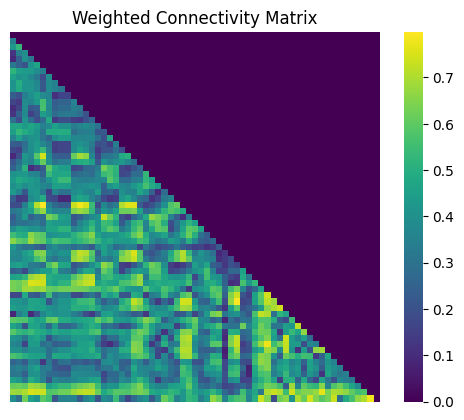

<ipython-input-22-b9910a3eba79>:69: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(connectivity_matrix_symmetric, method='average')


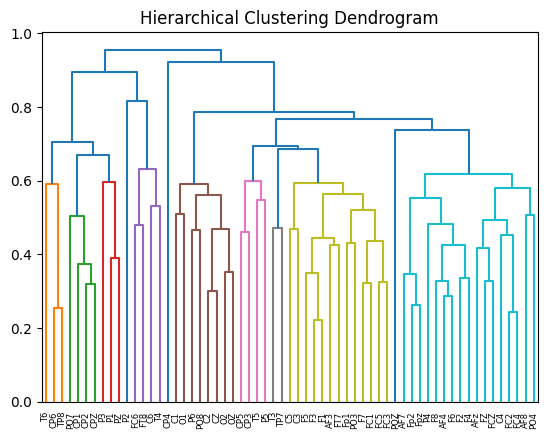

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Load the CSV file
file_path = '/content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ/BahTimPosleCleanICA_matrix_sensors_wpli.csv'
connectivity_matrix = pd.read_csv(file_path, index_col=0)

# Set diagonal elements to zero
np.fill_diagonal(connectivity_matrix.values, 0)

# Choose a threshold
threshold = 0.5

# Apply thresholding to create a binary matrix
binary_matrix = (connectivity_matrix > threshold).astype(int)

# Calculate Global Connectivity Index
global_connectivity_index = connectivity_matrix.mean().mean()
print(f"Global Connectivity Index: {global_connectivity_index}")

# Calculate Network Density
network_density = np.sum(binary_matrix.values) / (len(binary_matrix) * (len(binary_matrix) - 1))
print(f"Network Density: {network_density}")

# Create a graph from the binary matrix
G_binary = nx.Graph(binary_matrix)

# Calculate Clustering Coefficient for the largest connected component
largest_cc = max(nx.connected_components(G_binary), key=len)
subgraph = G_binary.subgraph(largest_cc)
clustering_coefficient_lcc = nx.average_clustering(subgraph)
print(f"Clustering Coefficient (Largest CC): {clustering_coefficient_lcc}")

# Calculate Average Path Length for the largest connected component
average_path_length = nx.average_shortest_path_length(subgraph)
print(f"Average Path Length (Largest CC): {average_path_length}")

# Generate a random graph with the same number of nodes and approximately the same number of edges
random_graph = nx.gnm_random_graph(n=G_binary.number_of_nodes(), m=G_binary.number_of_edges())

# Find the largest connected component in the random graph
largest_cc_random = max(nx.connected_components(random_graph), key=len)
subgraph_random = random_graph.subgraph(largest_cc_random)

# Calculate clustering coefficient and average path length for the largest connected component of the random graph
random_clustering_coefficient = nx.average_clustering(subgraph_random)
random_path_length = nx.average_shortest_path_length(subgraph_random)

# Calculate Small-World Index (sigma)
sigma = (clustering_coefficient_lcc / random_clustering_coefficient) / (average_path_length / random_path_length)
print(f"Small-World Index: {sigma}")


# Visualization
# Plot the weighted connectivity matrix
sns.heatmap(connectivity_matrix, cmap='viridis', square=True, xticklabels=False, yticklabels=False)
plt.title('Weighted Connectivity Matrix')
plt.show()

# Ensure the connectivity_matrix is symmetric (for hierarchical clustering)
connectivity_matrix_symmetric = (connectivity_matrix + connectivity_matrix.T) / 2

# Perform hierarchical clustering
linkage_matrix = linkage(connectivity_matrix_symmetric, method='average')

# Plot the dendrogram
dendrogram(linkage_matrix, labels=connectivity_matrix_symmetric.columns)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()


In [ ]:
!pip install python-louvain

In [ ]:
import community as community_louvain

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import community as community_louvain # Ensure this is installed

# Assuming your CSV loading and preprocessing here...

# Your previous code for network analysis...

# Calculate Global Efficiency
global_efficiency = nx.global_efficiency(G_binary)
print(f"Global Efficiency: {global_efficiency}")



Global Efficiency: 0.6080145719489973


In [ ]:
!pip install --upgrade networkx

In [ ]:
import networkx as nx
import networkx.algorithms.community as nx_comm


# Community detection with the Louvain method using networkx
communities = nx_comm.louvain_communities(G_binary)
modularity = nx_comm.modularity(G_binary, communities)
print(f"Modularity: {modularity}")


Modularity: 0.22713825899870227


Global Connectivity Index: 0.20157959562147942
Network Density: 0.13224043715846995
Average Connectivity Strength: 0.20157959562147942
Network Integration or Efficiency: 1.0
Clustering Coefficient: 0.24330388807660158


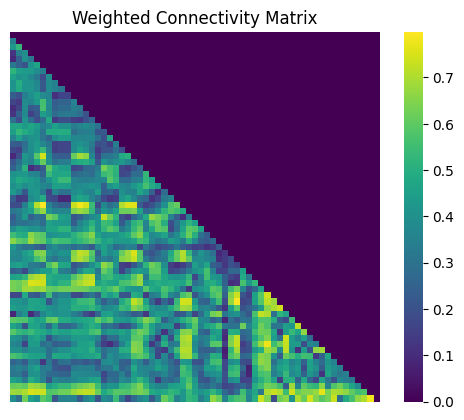

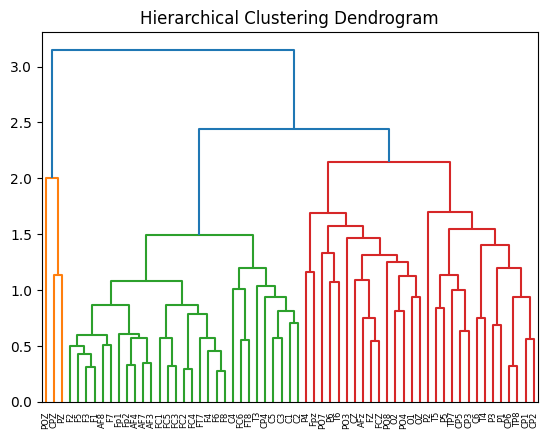

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Load the CSV file
file_path = '/content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ/BahTimPosleCleanICA_matrix_sensors_wpli.csv'
connectivity_matrix = pd.read_csv(file_path, index_col=0)

# Set diagonal elements to zero (optional, depends on your preference)
np.fill_diagonal(connectivity_matrix.values, 0)

# Choose a threshold based on your preference
threshold = 0.5  # You can adjust this value based on your dataset and goals

# Apply thresholding to create a binary matrix
binary_matrix = (connectivity_matrix > threshold).astype(int)

# Calculate Global Connectivity Index
global_connectivity_index = connectivity_matrix.mean().mean()
print(f"Global Connectivity Index: {global_connectivity_index}")

# Calculate Network Density
network_density = np.sum(binary_matrix.values) / (len(binary_matrix) * (len(binary_matrix) - 1))
print(f"Network Density: {network_density}")

# Calculate Average Connectivity Strength
average_connectivity_strength = connectivity_matrix.mean().mean()
print(f"Average Connectivity Strength: {average_connectivity_strength}")

# Calculate Network Integration or Efficiency using networkx
G = nx.from_pandas_adjacency(connectivity_matrix)
network_efficiency = nx.global_efficiency(G)
print(f"Network Integration or Efficiency: {network_efficiency}")

# Calculate Clustering Coefficient
clustering_coefficient = np.mean(binary_matrix.corr().mean())
print(f"Clustering Coefficient: {clustering_coefficient}")

# Visualization
# Plot the weighted connectivity matrix
sns.heatmap(connectivity_matrix, cmap='viridis', square=True, xticklabels=False, yticklabels=False)
plt.title('Weighted Connectivity Matrix')
plt.show()

# Create a hierarchical clustering dendrogram
linkage_matrix = linkage(connectivity_matrix.values, method='average', metric='euclidean')
dendrogram(linkage_matrix, labels=connectivity_matrix.columns)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()


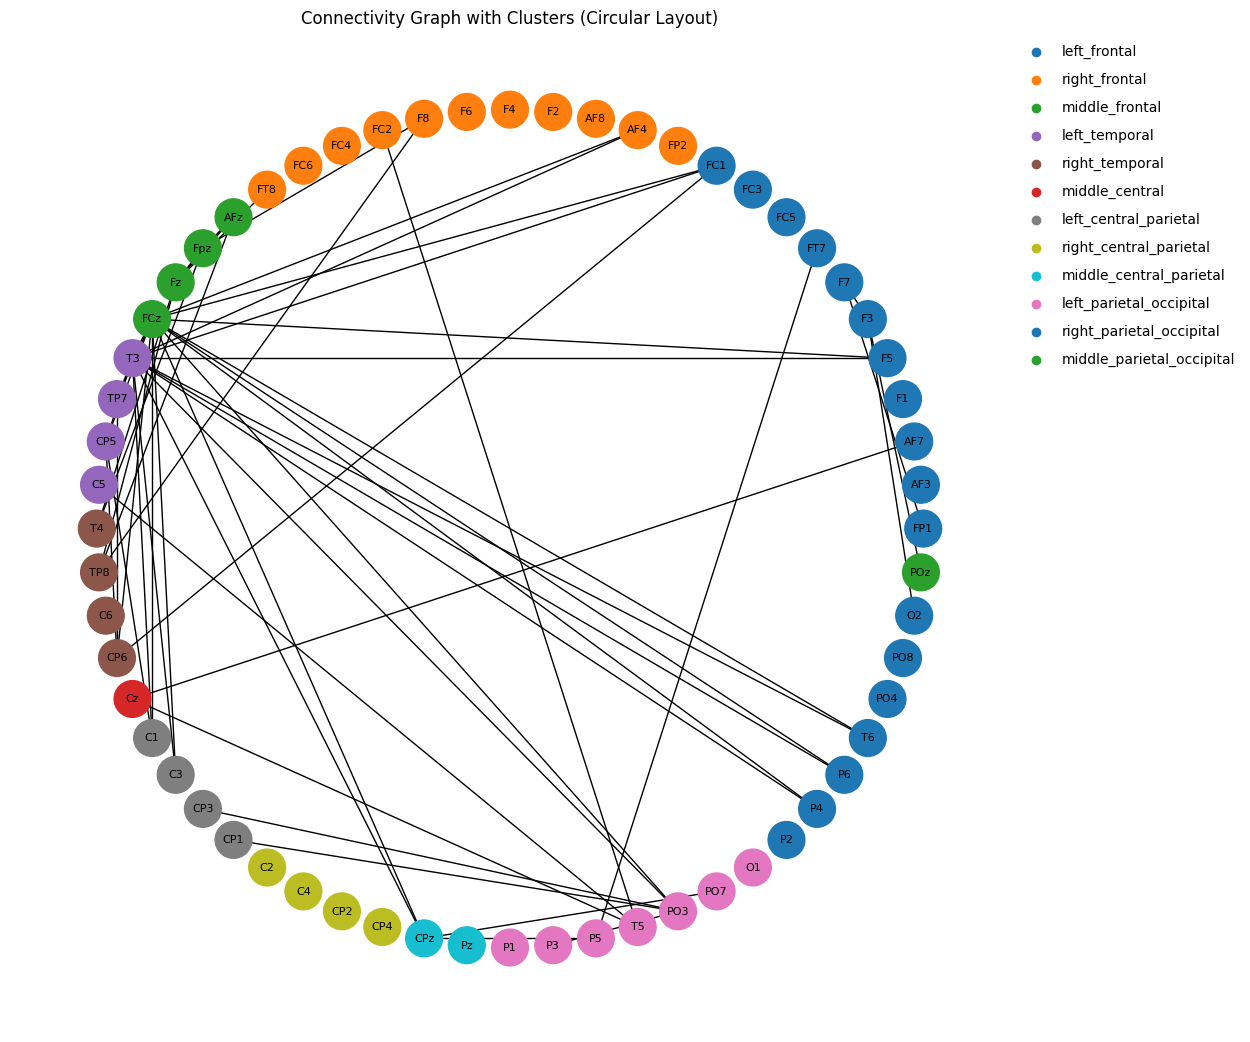

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the connectivity matrix file
file_path = '/content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ/IliYarDoCleanICA_matrix_sensors_wpli.csv'
connectivity_matrix = pd.read_csv(file_path, index_col=0)

# Set diagonal elements to zero (optional, depends on your preference)
connectivity_matrix.values[np.diag_indices_from(connectivity_matrix)] = 0

# Choose a threshold based on your preference
threshold = 0.5  # You can adjust this value based on your dataset and goals

# Apply thresholding to create a binary matrix
binary_matrix = (connectivity_matrix > threshold).astype(int)

# Create a graph using networkx
G = nx.from_pandas_adjacency(binary_matrix)

# Define the order of electrodes
electrode_order = [
    'FP1', 'AF3', 'AF7', 'F1', 'F5', 'F3', 'F7', 'FT7', 'FC5', 'FC3', 'FC1',
    'FP2', 'AF4', 'AF8', 'F2', 'F4', 'F6', 'F8', 'F8', 'FC2', 'FC4', 'FC6', 'FT8',
    'AFz', 'Fpz', 'Fz', 'FCz', 'T3', 'TP7', 'CP5', 'C5', 'T4', 'TP8', 'C6', 'CP6',
    'Cz', 'C1', 'C3', 'CP3', 'CP1', 'C2', 'C4', 'CP2', 'CP4', 'CPz', 'Pz',
    'P1', 'P3', 'P5', 'T5', 'PO3', 'PO7', 'O1', 'P2', 'P4', 'P6', 'T6', 'PO4', 'PO8', 'O2', 'POz','Oz'
]

# Arrange nodes in the specified order
G = nx.relabel_nodes(G, {node: electrode_order[index] for index, node in enumerate(G.nodes)})

# Define clusters based on your specified regions
clusters = {
    'left_frontal': ['FP1', 'AF3', 'AF7', 'F1', 'F5', 'F3', 'F7', 'FT7', 'FC5', 'FC3', 'FC1'],
    'right_frontal': ['FP2', 'AF4', 'AF8', 'F2', 'F4', 'F6', 'F8', 'F8', 'FC2', 'FC4', 'FC6', 'FT8'],
    'middle_frontal': ['AFz', 'Fpz', 'Fz', 'FCz'],
    'left_temporal': ['T3', 'TP7', 'CP5', 'C5'],
    'right_temporal': ['T4', 'TP8', 'C6', 'CP6'],
    'middle_central': ['Cz'],
    'left_central_parietal': ['C1', 'C3', 'CP3', 'CP1'],
    'right_central_parietal': ['C2', 'C4', 'CP2', 'CP4'],
    'middle_central_parietal': ['CPz', 'Pz'],
    'left_parietal_occipital': ['P1', 'P3', 'P5', 'T5', 'PO3', 'PO7', 'O1'],
    'right_parietal_occipital': ['P2', 'P4', 'P6', 'T6', 'PO4', 'PO8', 'O2'],
    'middle_parietal_occipital': ['POz', 'Oz']
}

# Assign nodes to clusters
default_cluster = 'other'
for node in G.nodes:
    assigned_cluster = default_cluster
    for cluster_name, cluster_nodes in clusters.items():
        if node in cluster_nodes:
            assigned_cluster = cluster_name
            break
    G.nodes[node]['cluster'] = assigned_cluster

# Positioning of nodes on the graph
pos = nx.circular_layout(G)  # Circular layout for all nodes

# Get cluster information for each node
node_cluster_mapping = nx.get_node_attributes(G, 'cluster')

# Map cluster names to colors
cluster_colors = {
    'left_frontal': '#1f77b4',   # blue
    'right_frontal': '#ff7f0e',  # orange
    'middle_frontal': '#2ca02c', # green
    'left_temporal': '#9467bd',  # purple
    'right_temporal': '#8c564b', # brown
    'middle_central': '#d62728',  # red
    'left_central_parietal': '#7f7f7f',   # gray
    'right_central_parietal': '#bcbd22',  # olive
    'middle_central_parietal': '#17becf', # teal
    'left_parietal_occipital': '#e377c2', # pink
    'right_parietal_occipital': '#1f77b4',# blue (reuse)
    'middle_parietal_occipital': '#2ca02c' # green (reuse)
}

# Assign colors to nodes based on their clusters
node_colors = [cluster_colors[node_cluster_mapping[node]] for node in G.nodes]

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, node_size=700, node_color=node_colors, font_size=8)

# Draw legend for clusters
for cluster_name, color in cluster_colors.items():
    plt.scatter([], [], c=color, label=cluster_name)

plt.title('Connectivity Graph with Clusters (Circular Layout)')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [ ]:
# Check if 'Oz' is in the list of electrodes
if 'OZ' not in G.nodes:
    print("Warning: 'Oz' not found in the list of electrodes.")


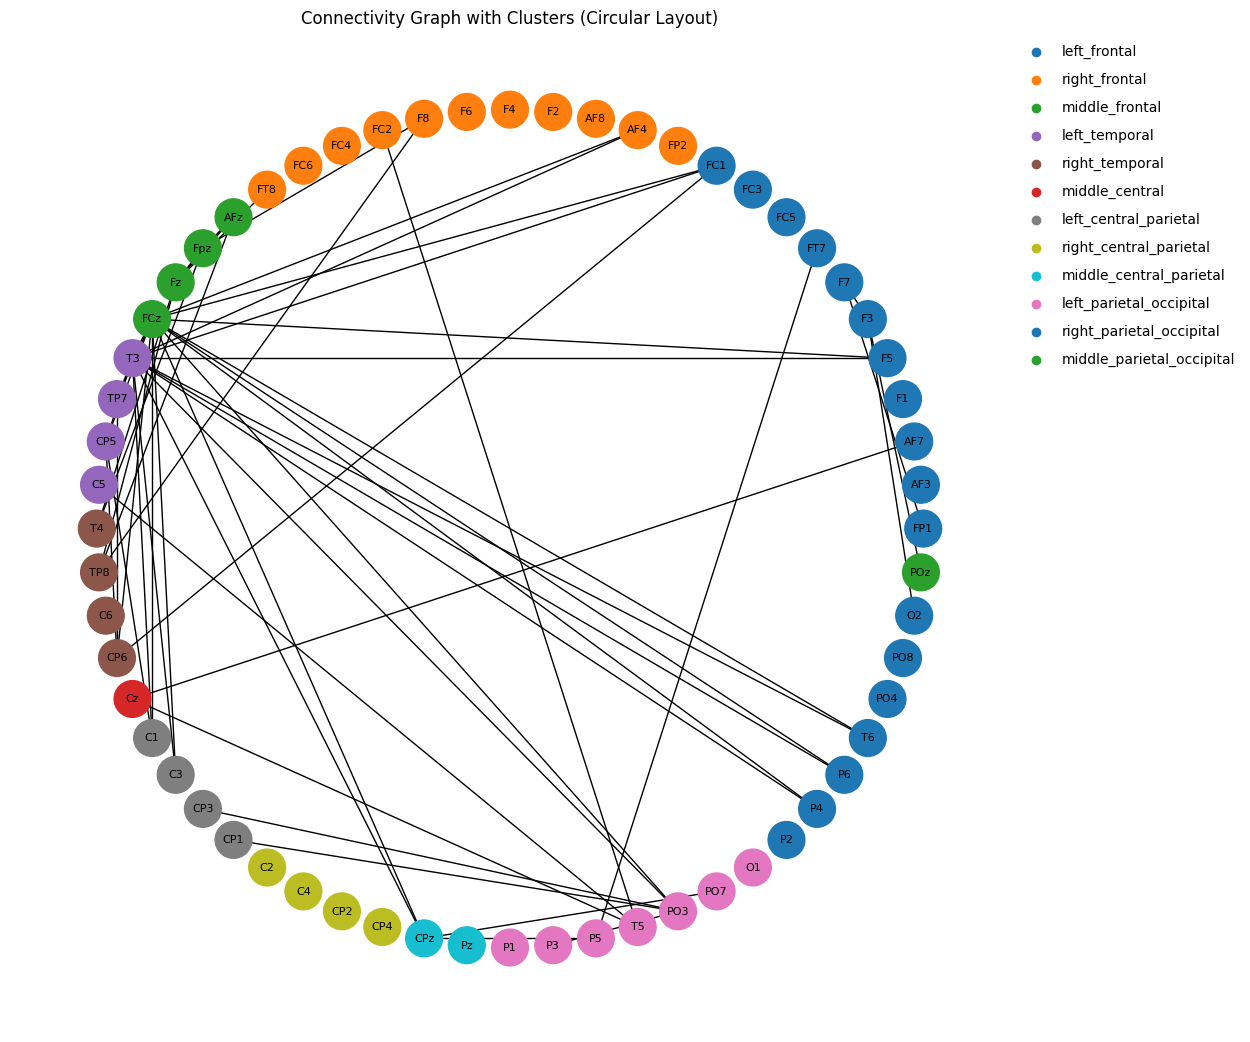

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the connectivity matrix file
file_path = '/content/gdrive/My Drive/Colab Notebooks/Обработанные ЭЭГ/IliYarDoCleanICA_matrix_sensors_wpli.csv'
connectivity_matrix = pd.read_csv(file_path, index_col=0)

# Set diagonal elements to zero (optional, depends on your preference)
connectivity_matrix.values[np.diag_indices_from(connectivity_matrix)] = 0

# Choose a threshold based on your preference
threshold = 0.5  # You can adjust this value based on your dataset and goals

# Apply thresholding to create a binary matrix
binary_matrix = (connectivity_matrix > threshold).astype(int)

# Create a graph using networkx
G = nx.from_pandas_adjacency(binary_matrix)

# Define the order of electrodes
electrode_order = [
    'FP1', 'AF3', 'AF7', 'F1', 'F5', 'F3', 'F7', 'FT7', 'FC5', 'FC3', 'FC1',
    'FP2', 'AF4', 'AF8', 'F2', 'F4', 'F6', 'F8', 'F8', 'FC2', 'FC4', 'FC6', 'FT8',
    'AFz', 'Fpz', 'Fz', 'FCz', 'T3', 'TP7', 'CP5', 'C5', 'T4', 'TP8', 'C6', 'CP6',
    'Cz', 'C1', 'C3', 'CP3', 'CP1', 'C2', 'C4', 'CP2', 'CP4', 'CPz', 'Pz',
    'P1', 'P3', 'P5', 'T5', 'PO3', 'PO7', 'O1', 'P2', 'P4', 'P6', 'T6', 'PO4', 'PO8', 'O2', 'POz','Oz'
]

# Check if 'Oz' is in the list of electrodes
if 'Oz' not in G.nodes:
    print("Warning: 'Oz' not found in the list of electrodes.")

# Arrange nodes in the specified order
G = nx.relabel_nodes(G, {node: electrode_order[index] for index, node in enumerate(G.nodes)})

# Define clusters based on your specified regions
clusters = {
    'left_frontal': ['FP1', 'AF3', 'AF7', 'F1', 'F5', 'F3', 'F7', 'FT7', 'FC5', 'FC3', 'FC1'],
    'right_frontal': ['FP2', 'AF4', 'AF8', 'F2', 'F4', 'F6', 'F8', 'F8', 'FC2', 'FC4', 'FC6', 'FT8'],
    'middle_frontal': ['AFz', 'Fpz', 'Fz', 'FCz'],
    'left_temporal': ['T3', 'TP7', 'CP5', 'C5'],
    'right_temporal': ['T4', 'TP8', 'C6', 'CP6'],
    'middle_central': ['Cz'],
    'left_central_parietal': ['C1', 'C3', 'CP3', 'CP1'],
    'right_central_parietal': ['C2', 'C4', 'CP2', 'CP4'],
    'middle_central_parietal': ['CPz', 'Pz'],
    'left_parietal_occipital': ['P1', 'P3', 'P5', 'T5', 'PO3', 'PO7', 'O1'],
    'right_parietal_occipital': ['P2', 'P4', 'P6', 'T6', 'PO4', 'PO8', 'O2'],
    'middle_parietal_occipital': ['POz', 'Oz']
}

# Assign nodes to clusters
default_cluster = 'other'
for node in G.nodes:
    assigned_cluster = default_cluster
    for cluster_name, cluster_nodes in clusters.items():
        if node in cluster_nodes:
            assigned_cluster = cluster_name
            break
    G.nodes[node]['cluster'] = assigned_cluster

# Positioning of nodes on the graph
pos = nx.circular_layout(G)  # Circular layout for all nodes

# Get cluster information for each node
node_cluster_mapping = nx.get_node_attributes(G, 'cluster')

# Map cluster names to colors
cluster_colors = {
    'left_frontal': '#1f77b4',   # blue
    'right_frontal': '#ff7f0e',  # orange
    'middle_frontal': '#2ca02c', # green
    'left_temporal': '#9467bd',  # purple
    'right_temporal': '#8c564b', # brown
    'middle_central': '#d62728',  # red
    'left_central_parietal': '#7f7f7f',   # gray
    'right_central_parietal': '#bcbd22',  # olive
    'middle_central_parietal': '#17becf', # teal
    'left_parietal_occipital': '#e377c2', # pink
    'right_parietal_occipital': '#1f77b4',# blue (reuse)
    'middle_parietal_occipital': '#2ca02c' # green (reuse)
}

# Assign colors to nodes based on their clusters
node_colors = [cluster_colors[node_cluster_mapping[node]] for node in G.nodes]

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, node_size=700, node_color=node_colors, font_size=8)

# Draw legend for clusters
for cluster_name, color in cluster_colors.items():
    plt.scatter([], [], c=color, label=cluster_name)

plt.title('Connectivity Graph with Clusters (Circular Layout)')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
